In [2]:
# Base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ARIMA and VAR model libaries
from scipy import stats
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

# Random Forest libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import norm

# Hide warning messages to read outputs easier
import warnings
warnings.filterwarnings("ignore")

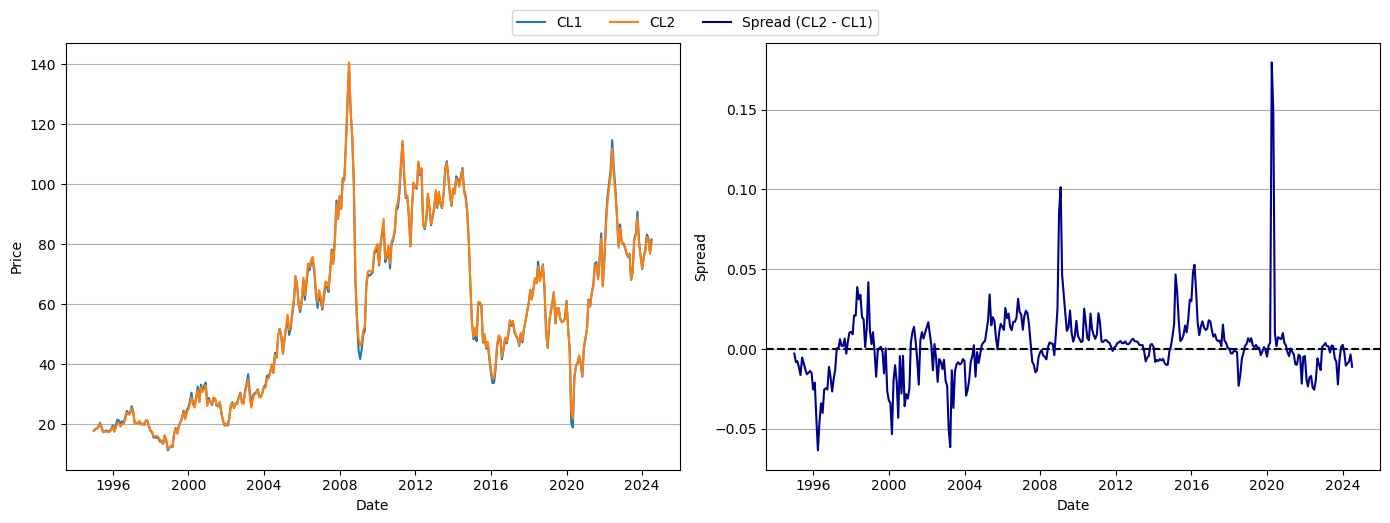

In [3]:
# Import relevant sheets from Excel file
industry_monthly_data = pd.read_excel('Oil Data.xlsx', sheet_name='Industry_M')
macro_data = pd.read_excel('Oil Data.xlsx', sheet_name='Macro_M')
stock_prices = pd.read_excel('Oil Data.xlsx', sheet_name='StockPrices_M')

# Create new column for the oil prices spread
industry_monthly_data['Spread'] = np.log(industry_monthly_data['CL2']) - np.log(industry_monthly_data['CL1'])

# Convert date columns into datetime format
industry_monthly_data['Date'] = pd.to_datetime(industry_monthly_data['Date'])
macro_data['Date'] = pd.to_datetime(macro_data['Date'])
stock_prices['Date'] = pd.to_datetime(stock_prices['Date'])
last_date = industry_monthly_data['Date'].max()

# Converted date frequency into monthly
industry_monthly_data['Date'] = industry_monthly_data['Date'].dt.to_period('M').dt.to_timestamp('M')
macro_data['Date'] = macro_data['Date'].dt.to_period('M').dt.to_timestamp('M')
stock_prices['Date'] = stock_prices['Date'].dt.to_period('M').dt.to_timestamp('M')

# Merged the separate datasets into one large dataset
merged_data = industry_monthly_data.merge(macro_data, on='Date', how='inner')
merged_data = merged_data.merge(stock_prices, on='Date', how='inner')
merged_data = merged_data.sort_values('Date')

# Plot the prices and spread for visualisation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].grid(axis='y')
ax[0].plot(merged_data['Date'], merged_data['CL1'], label="CL1")
ax[0].plot(merged_data['Date'], merged_data['CL2'], label="CL2")
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price')

ax[1].grid(axis='y')
ax[1].axhline(y=0, color='black', linestyle='--')
ax[1].plot(merged_data['Date'], merged_data['Spread'], color='darkblue', label='Spread (CL2 - CL1)')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Spread')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

plt.tight_layout()

# Drop unneccessary columns
merged_data = merged_data.drop(columns=['CL1', 'CL2', 'Total Open Interest', 'Shell'])

In [12]:
# AdFuller test 
for i in merged_data:
    if i == "Date": # Ignore the Date column
        continue
    adfullertest = adfuller(merged_data[i].dropna())
    # print(f"{i} p-value: {adfullertest[1]:.3f}")
    if adfullertest[1] > 0.05: # Difference any column if p-value > 0.05 (i.e. non stationary)
        merged_data[i] = merged_data[i].diff()
merged_data_adfuller_cleaned = merged_data.dropna()

# KPSS test
for i in merged_data:
    if i == "Date": # Ignore the Date column
        continue
    kpsstest = adfuller(merged_data[i].dropna())
    if kpsstest[1] > 0.05: # Difference any column if p-value > 0.05 (i.e. non stationary)
        merged_data[i] = merged_data[i].diff()
merged_data_kpss_cleaned = merged_data.dropna()

In [13]:
model_vars = ['Brent', 'CRKS321C Index', 'Baltic Dry Index',
       'Daily Production', 'Inventories', 'Rig Count', 'Commercial Long',
       'Commercial Short', 'Spread', 'CPI YOY %', '3M Yield', '10Y Yield',
       'IndustrialProduction Index', 'SPX', 'DXY returns', 'VIX',
       'Gasoline All Grades', 'Dow Jones US Oil&Gas Index']

significant_vars = ['Spread']
for i in model_vars:
    if i != 'Spread':
        gctest = grangercausalitytests(merged_data_adfuller_cleaned[['Spread', i]], maxlag=12, verbose=False)
        p_values = min(gctest[lag][0]['ssr_ftest'][1] for lag in range(1, 12))
        print(f"Variable: {i}, p-values: {p_values}")
        if p_values < 0.05:
            significant_vars.append(i)

print("Significant variables are:", significant_vars)
    

Variable: Brent, p-values: 0.00044824726120029575
Variable: CRKS321C Index, p-values: 0.5468943835740339
Variable: Baltic Dry Index, p-values: 0.00023947987645098938
Variable: Daily Production, p-values: 0.04716508511109964
Variable: Inventories, p-values: 0.02203867129298361
Variable: Rig Count, p-values: 0.6789190392183924
Variable: Commercial Long, p-values: 0.28165626955501877
Variable: Commercial Short, p-values: 0.28067436372980975
Variable: CPI YOY %, p-values: 0.06019321113835445
Variable: 3M Yield, p-values: 0.0003021989983726789
Variable: 10Y Yield, p-values: 0.0012389935266441257
Variable: IndustrialProduction Index, p-values: 0.0001935472137389006
Variable: SPX, p-values: 0.0070204672823988125
Variable: DXY returns, p-values: 0.4105167697932707
Variable: VIX, p-values: 0.0019561635400292695
Variable: Gasoline All Grades, p-values: 0.0008221774440284121
Variable: Dow Jones US Oil&Gas Index, p-values: 0.0009397973234128558
Significant variables are: ['Spread', 'Brent', 'Balti